## ADA final exam (Fall 2022)

This exam consists of 3 tasks. Tasks 2 and 3 are independent of each other (although conceptually related).


In [2]:
#Test import

import os
import gzip
import random
import pickle
import re
import itertools
import collections
import operator
import requests
from urllib.parse import *
from datetime import *
from dateutil.parser import parse

import math
import sklearn
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import *

import ast
import gensim
import string
import nltk
import codecs
import json
import vaderSentiment
import spacy
from empath import Empath
from bs4 import BeautifulSoup

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

For a Wikipedia editor to become an administrator, a so-called “request for adminship” ([RfA](https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship)) must be submitted by either the candidate or another community member. Subsequently, any Wikipedia member may cast a supporting or opposing vote. Here we provide a simplified version of the Wikipedia RfA dataset, containing all votes from 2003 through 2012.

###  Data format

|        |   SRC |   TGT |   VOT |   RES |   YEA | DAT                 | TXT                                                                                                                                                                                               |
|-------:|------:|------:|------:|------:|------:|:--------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  39054 |  3444 | 10170 |     1 |     1 |  2009 | 2009-07-01 17:50:00 | '''Support''' - Best of luck. &nbsp;                                                                                                                                                              |
| 159680 |   722 |  9634 |    -1 |    -1 |  2006 | 2006-12-15 07:28:00 | '''Oppose''' Not even 2000 edits.                                                                                                                                                                 |
| 173438 |  4194 |  5524 |     1 |     1 |  2005 | 2005-03-18 19:22:00 | Ohhh, you're Carrp!  In that case, '''Support'''.                                                                                                                                                 |
|  60627 |  4855 |  9436 |     1 |     1 |  2008 | 2008-12-18 23:26:00 | '''Support''' via thoughtful answer to my question that demonstrates this editor has clue.                                                 |
| 194809 |  7687 |   908 |     1 |     1 |  2004 | 2004-09-25 05:21:00 | Nicholas is very good in English. Also, he got '''exceptional''' patience to explain petty obvious facts in talk page to convince ignorants. Let the world be benefitted more out of his work. -- |


- SRC: the user name of the source of the vote, i.e., of the user who cast the vote.
- TGT: the user name of the target of the vote, i.e., of the user running for election.
- VOT: the source's vote on the target (-1 = oppose; 1 = support).
- RES: the outcome of the election (-1 = target was rejected as admin; 1 = target was accepted). **(We will not use this  column in this exam.)**
- YEA: the year of the RfA.
- DAT: the date and time of this vote. **(We will not use this column in this exam.)**
- TXT: the comment written by the source. **(We will not use this column in this exam.)**

---


## Structural balance theory

**Structural balance theory** affirms that social networks tend to be organized so as to avoid conflictual situations, e.g., if a great friend of yours hates someone, you will likely not befriend that person.

The theory can be operationalized by looking at _triangles_ in an undirected _signed graph_ capturing person-to-person relationships, where a _signed graph_ is a  graph in which each edge is associated with a positive or negative sign, and a _triangle_ is a set of three edges ($\langle u,v \rangle$, $\langle v,w\rangle$, $\langle u,w\rangle$) that fully connect three distinct nodes ($u, v, w$).



_Triangles_ in an undirected signed graph can be in 4 _configurations_:
all positive edges ($\{+,+,+\}$); 
all negative edges ($\{-,-,-\}$); 
two positive edges and one negative edge ($\{+,+,-\}$);
one positive edge and two negative edges ($\{+,-,-\}$).

Structural balance theory posits that social networks tend to favor triangle configurations with an even number of negative signs (i.e., $\{+,+,+\}$ and $\{+,-,-\}$), which can be understood as being “balanced” by avoiding conflictual situations. Intuitively, $\{+,+,+\}$ could be tagged as “The friend of my friend is my friend”, and $\{+,-,-\}$ as “The enemy of my enemy is my friend”, “The friend of my enemy is my enemy”, or “The enemy of my friend is my enemy”. On the contrary, triangle configurations with an odd number of negative signs (i.e., $\{+,+,-\}$ and $\{-,-,-\}$) are unstable (“unbalanced”) according to structural balance theory and will thus occur less frequently in social networks. For instance, me being friends with two mutual enemies ($\{+,+,-\}$) would lead to tension that could be resolved if the two enemies became friends or if I took sides and ended my friendship with one of the two. Similarly, two among three mutual enemies ($\{-,-,-\}$) would have the incentive to form an alliance to “gang up” against the third.

Some social scientists have argued that three mutual enemies ($\{-,-,-\}$) is not necessarily a triangle configuration that social networks tend to avoid. This gives rise to **weak structural balance theory**, which only posits that social networks tend to avoid the “unbalanced” triangle configuration $\{+,+,-\}$.

In a nutshell,
- structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$ as balanced,
  - and $\{+,+,-\}$, $\{-,-,-\}$ as unbalanced;
- weak structural balance theory
  - considers $\{+,+,+\}$, $\{+,-,-\}$, $\{-,-,-\}$ as balanced,
  - and $\{+,+,-\}$ as unbalanced.



### Task 1: Preliminaries

As a good data scientist, you first load the data and explore it.

**1.1**
Load the csv file `wiki-RfA.csv.gz` in a pandas dataframe. Calculate the number of distinct RfAs and the average number of votes per RfA.
- **Hint:** Throughout this question, assume that each RfA is uniquely determined by the column `TGT` and each vote is uniquely determined by the combination of `SRC` and `TGT`.

In [7]:
# 1.1

rfa = pd.read_csv('wiki-RfA.csv')
rfa.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,5943,9966,-1,-1,2012,2012-12-30 22:27:00,—
1,9153,9966,-1,-1,2012,2012-12-30 22:25:00,"'''Oppose'''. This joke really isn't funny, no..."
2,4189,9966,-1,-1,2012,2012-12-30 22:17:00,'''Oppose''' as per nomination and answers. --...
3,3750,9966,-1,-1,2012,2012-12-30 22:14:00,'''Oppose''' and '''speeedy close''' this as [...
4,4225,9966,-1,-1,2012,2012-12-30 22:08:00,'''Oppose''' per nomination and answers. I am ...


In [13]:
print('Total number of Rfa: ' + str(len(rfa.TGT.value_counts())))

Total number of Rfa: 3439


In [50]:
tgt = rfa.groupby('TGT').SRC.unique()

In [54]:
tgt_tot = []

for i in range(len(tgt)):
    tgt_tot.append(len(tgt.values[i]))

In [82]:
print('Total number of average vote per Rfa: ' + str(np.mean(tgt_tot)))

Total number of average vote per Rfa: 48.561500436173304


**1.2** 
In a single figure with three subfigures (one per item), show the following time series:
- the number of RfAs per year;
- the overall fraction of positive votes per year; and 
- the average number of votes per RfA per year.

For each of the above three quantities, print the value for the year 2008.

In [33]:
# 1.2
years_rfa = rfa.groupby('YEA').TGT.unique()

In [52]:
years_rfa_tot = []

for i in range(len(years_rfa)):
    years_rfa_tot.append(len(years_rfa.values[i]))

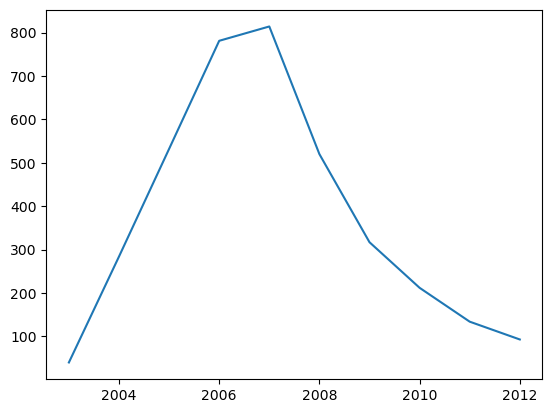

In [53]:
plt.plot(years_rfa.index, np.array(years_rfa_tot))
plt.show()

In [72]:
years = rfa.YEA.unique()

In [73]:
years

array([2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003],
      dtype=int64)

In [80]:
years_vot_tot = np.zeros(len(years))


for i,y in enumerate(years):
    
    years_vot_tot[i] = len(rfa[(rfa.YEA == y) & (rfa.VOT == 1)])/len(rfa[rfa.YEA == y])

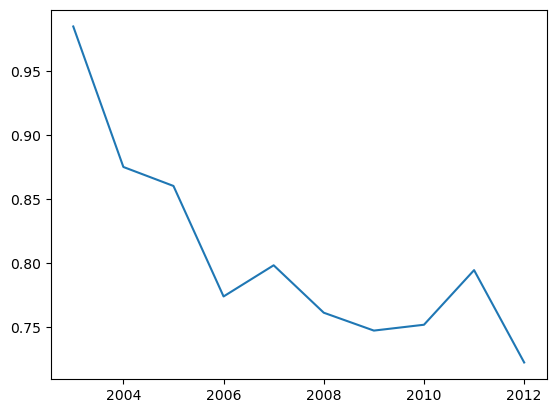

In [81]:
plt.plot(years, years_vot_tot)
plt.show()

In [84]:
years_tga_tot = np.zeros(len(years))

for i,y in enumerate(years):
    
    tgt_year = rfa[rfa.YEA == y].groupby('TGT').SRC.unique()
    
    tgt_tot = []

    for k in range(len(tgt_year)):
        tgt_tot.append(len(tgt_year.values[k]))
    
    years_tga_tot[i] = np.mean(tgt_tot)

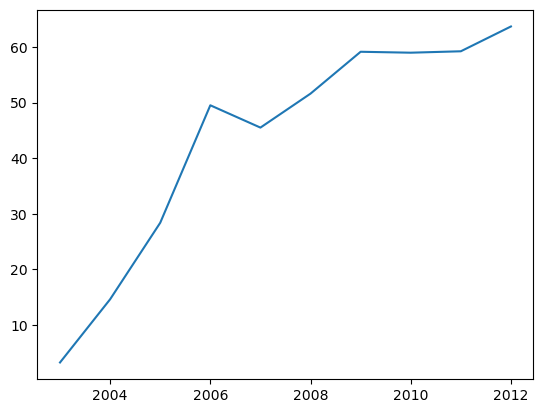

In [85]:
plt.plot(years, years_tga_tot)
plt.show()

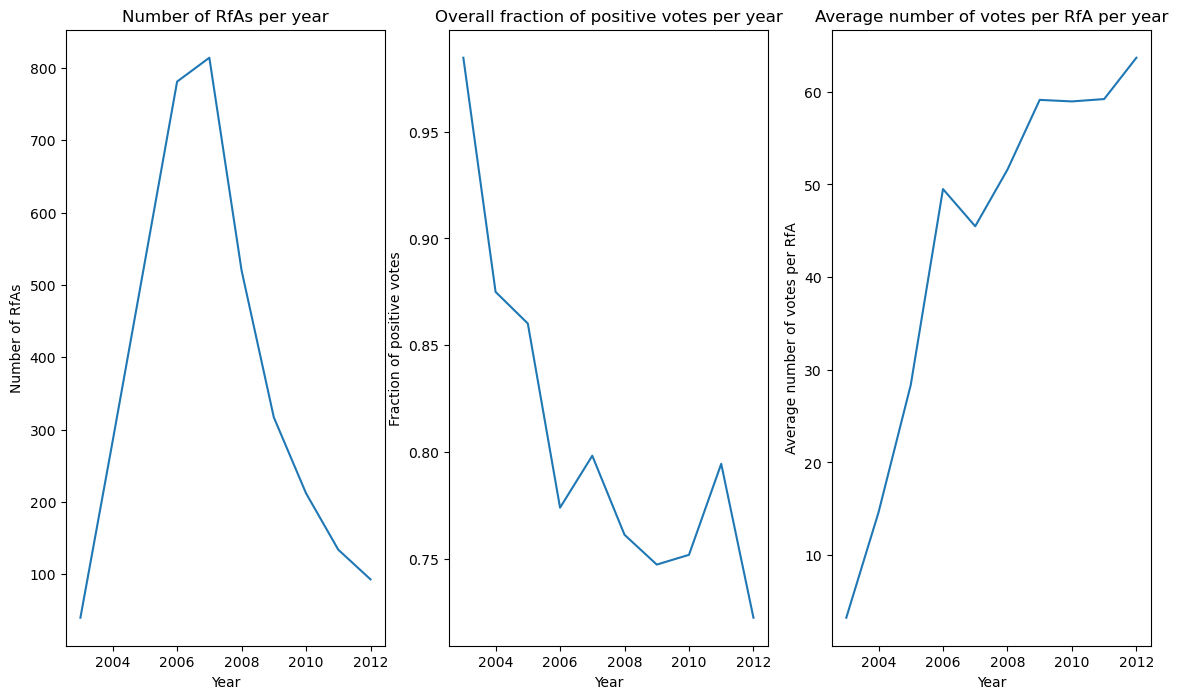

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(14,8), sharex = True)
#axs = axs.flatten()
axs[0].plot(years_rfa.index, np.array(years_rfa_tot))
axs[0].set_title('Number of RfAs per year')
axs[1].plot(years, years_vot_tot)
axs[1].set_title('Overall fraction of positive votes per year')
axs[2].plot(years, years_tga_tot)
axs[2].set_title('Average number of votes per RfA per year')
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[2].set_xlabel('Year')
axs[0].set_ylabel('Number of RfAs')
axs[1].set_ylabel('Fraction of positive votes')
axs[2].set_ylabel('Average number of votes per RfA')
plt.show()

In [124]:
print('Number of RfAs in 2008: ' + str(np.array(years_rfa_tot)[5]))

Number of RfAs in 2008: 520


In [125]:
print('Number of RfAs in 2008: ' + str(years_vot_tot[4]))


Number of RfAs in 2008: 0.7612268475384787


In [126]:
print('Number of RfAs in 2008: ' + str(years_tga_tot[4]))

Number of RfAs in 2008: 51.60192307692308


**1.3** 
**/Discuss:/** Describe the temporal patterns observed in the plots you did in **T1.2**.

**A1.3** 
*YOUR ANSWER HERE*

It seems that the overall fraction of positive votes per year is decreasing over time but has somo small increases sometimes. On the other hand the average number of votes per RfA per year is increasing with the years. While the number of RfAs per year reached a pick around 2007 and now it is very low again.

**1.4** 
Create an undirected graph ([`nx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html)) where every node corresponds to a Wikipedia user (source or target of an RfA) and where there exists an edge between two users if at least one of them has voted on the other. Each edge should have attributes corresponding to columns of the dataframe, namely:
- `VOT`, which equals `1` if the vote was positive, and `-1` otherwise.
- `YEA`, an integer that represents the year of the RfA.

**The code to load the graph has been provided to you!** After running it, print the number of nodes and edges in your graph.

---

**Observation:** Note that we have at most one edge per pair of nodes in the graph, even though two votes may be associated with the pair  — e.g., if A voted in B's RfA in time $t_1$ and B voted in A's RfA in time $t_2$ ($t_1 < t_2$). In these cases, the code provided associates the metadata of the oldest vote ($t_1$ in the example) to the edge between A and B.

In [87]:
# Provided code! Do not change!
import networkx as nx
import pandas as pd
G = nx.from_pandas_edgelist(pd.read_csv("./wiki-RfA.csv"), 
                            'SRC', 'TGT', ['VOT', 'RES', 'YEA', 'DAT'], create_using=nx.Graph)

In [88]:
# 1.4
nx.info(G)

C:\Users\lisap\AppData\Local\Temp\ipykernel_8528\3095922694.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 10831 nodes and 161147 edges'

**1.5** 
Plot the **complementary** cumulative distribution of the degree centrality of the undirected graph. Use a logarithmic (base 10) x-axis and a linear y-axis.

In [89]:
# 1.5
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [90]:
degree = degree_histogram_directed(G)

In [94]:
cdf = np.array(degree).cumsum() / np.array(degree).sum()
ccdf = 1 - cdf

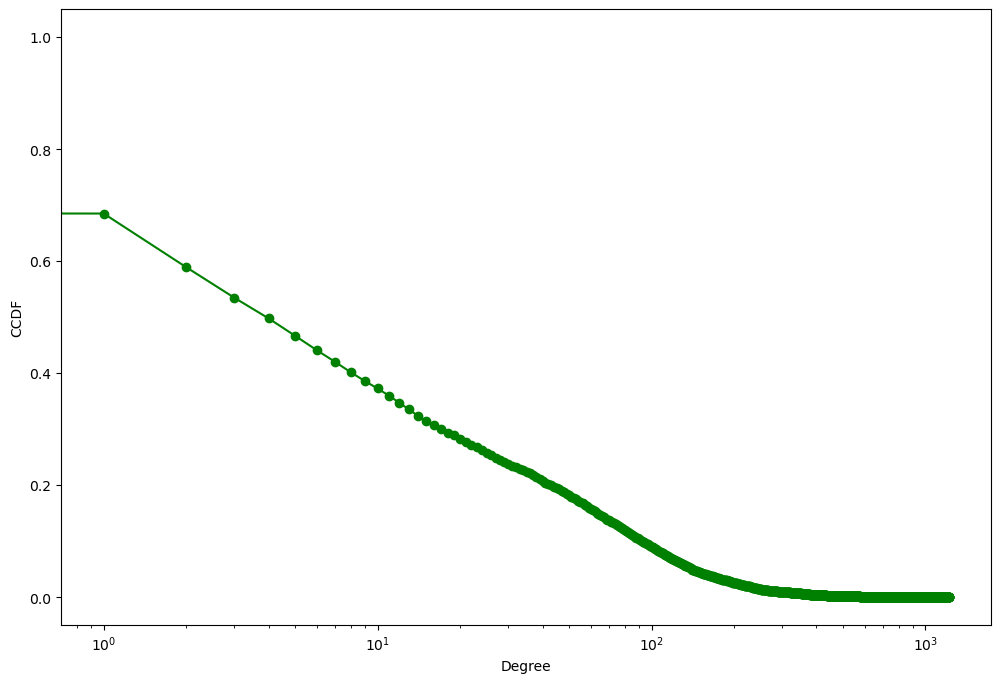

In [95]:
plt.figure(figsize=(12, 8)) 
plt.plot(range(len(degree)), ccdf, 'go-', label='CCDF degree')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.show()


**1.6**
**/Discuss:/** Why is the following statement false? Justify your answer. **"From the graph obtained in task 1.5, one can conclude that around 40% of the users voted at least 11 times."**


**A1.6**
*YOUR ANSWER HERE*


The plot above consider the degree of each node but since the graph is undirected we lose the information about who voted how. It is therefore not possible to say about the number of voted we can only claim that around 30% of nodes are connected with at least 11 other nodes.

**1.7**
What fraction of users voted at least 11 times? Use the data to measure the fraction.

In [101]:
# 1.7

sum(rfa.SRC.value_counts() >= 11)

2693

In [105]:
print('Fraction of users that voted at least 11 times: ' + str(sum(rfa.SRC.value_counts() >= 11) / len(rfa.SRC.value_counts())))

Fraction of users that voted at least 11 times: 0.27459977567043947


### Task 2: Triangles

Next, you set out to investigate the social balance theory by looking at the RfA graph.

**2.1**
Considering _only_ the RfAs of 2004 (i.e., where `YEA == 2004`), generate all triangles in the undirected graph.
Print the number of triangles found.
- **Hint:** Note that you can generate a graph with only a subset of nodes and edges via ` G.edge_subgraph`.
-  **Hint:** The function `nx.enumerate_all_cliques` generates all cliques in an undirected graph. First, all cliques of size 1 are generated, then all cliques of size 2, etc. Triangles are cliques of size 3.


In [127]:
# 2.1

rfa_2004 = rfa[rfa.YEA == 2004]

In [140]:
G_2004 = nx.from_pandas_edgelist(rfa_2004, 
                            'SRC', 'TGT', ['VOT', 'RES', 'YEA', 'DAT'], create_using=nx.Graph)

In [150]:
nx.info(G_2004)

C:\Users\lisap\AppData\Local\Temp\ipykernel_8528\2121001832.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_2004)


'Graph with 603 nodes and 4065 edges'

In [270]:
def get_cliques_by_length(G, length_clique):
    """ Return the list of all cliques in an undirected graph G with length
    equal to length_clique. """
    cliques = []
    for c in nx.enumerate_all_cliques(G):
        if len(c)   <= length_clique:
            if len(c) == length_clique:
                cliques.append(c)
        else:
            return cliques
    # return empty list if nothing is found
    return cliques

triangles = get_cliques_by_length(G_2004, 3)

In [277]:
print('Numer of triangles: ' + str(len(triangles)))

Numer of triangles: 8448


**2.2 ** **/True or false:/** Is the following statement true or false? Justify your answer. **"The node with the highest clustering coefficient in an undirected graph is the node that belongs to the largest number of triangles."**

**A2.2**
*YOUR ANSWER HERE*

False, if the triangles of a node are not connected between them the clustering coefficient is lower that a node connected with just one triangle.

**2.3** Considering the set of triangles previously calculated, estimate the fraction of triangles of configurations
 $\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, and $\{+,-,-\}$. What fraction of triangles are "balanced" according to structural balance theory?

**Sorry but my computer is not fast enough to run 2.3 and 2.4 in time. I hope you can still look at the code.**

In [ ]:
conf1 = 0
conf2 = 0
conf3 = 0
conf4 = 0

for i,j,l in triangles:
    summ = 0
    for node1, node2, data in G.edges(data=True):
        if (node1 in (i,j,l)) and (node2 in (i,j,l)):
            summ += data['VOT']
            
    if summ == 3:
        conf1 += 1
        
    if summ == -3:
        conf2 += 1
        
    if summ == 1:
        conf3 += 1
        
    if summ == -1:
        conf4 += 1
    

In [ ]:
# 2.3
print('Balanced fraction: ' + str((conf1+conf4)/len(triangles)))

print('Unbalanced fraction: ' + str((conf2+conf3)/len(triangles)))

print('Conf +++ fraction: ' + str(conf1/len(triangles)))

print('Conf --- fraction: ' + str(conf2/len(triangles)))

print('Conf ++- fraction: ' + str(conf3/len(triangles)))

print('Conf +-- fraction: ' + str(conf4/len(triangles)))

**2.4** To observe how triangle configurations would be distributed under a random null model, do the following:
- Create a new column `VOT_RND` in the dataframe, where RfA votes (i.e., edge signs in the graph) are shuffled, i.e., permuted randomly.  For shuffling, use `numpy.random`, without replacement and with the seed 32 (see code provided below).
- Create a new edge attribute with the values of `VOT_RND` in the graph you created in task **1.4**. You can do this easily using the  [`set_edge_attributes`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.set_edge_attributes.html) function.
- Considering the shuffled edge signs,  compute the fraction of triangles in each configuration ($\{+,+,+\}$,  $\{-,-,-\}$,  $\{+,+,-\}$, $\{+,-,-\}$). Moreover, compute the fraction of triangles that are "balanced" according to structural balance theory. (Reminder: consider only the RfAs of 2004.)


In [272]:
# PROVIDED STUB FOR 2.4
import numpy as np
np.random.seed(32)
df_2004 = rfa[rfa.YEA == 2004].copy(deep=True)
df_2004["VOT_RND"] = np.random.choice(df_2004["VOT"].values, size=len(df_2004), replace=False)

In [274]:
# 2.4

G_RND = nx.from_pandas_edgelist(df_2004, 'SRC', 'TGT', ['VOT_RND', 'VOT', 'RES', 'YEA', 'DAT'], create_using=nx.Graph)

In [ ]:
triangles_RNG = get_cliques_by_length(G_RNG, 3)

In [ ]:
print('Numer of triangles: ' + str(len(triangles_RNG)))

In [ ]:
conf1 = 0
conf2 = 0
conf3 = 0
conf4 = 0

for i,j,l in triangles:
    summ = 0
    for node1, node2, data in G.edges(data=True):
        if (node1 in (i,j,l)) and (node2 in (i,j,l)):
            summ += data['VOT']
            
    if summ == 3:
        conf1 += 1
        
    if summ == -3:
        conf2 += 1
        
    if summ == 1:
        conf3 += 1
        
    if summ == -1:
        conf4 += 1
    

In [ ]:
print('Balanced fraction: ' + str((conf1+conf4)/len(triangles)))

print('Unbalanced fraction: ' + str((conf2+conf3)/len(triangles)))

print('Conf +++ fraction: ' + str(conf1/len(triangles)))

print('Conf --- fraction: ' + str(conf2/len(triangles)))

print('Conf ++- fraction: ' + str(conf3/len(triangles)))

print('Conf +-- fraction: ' + str(conf4/len(triangles)))

**2.5** **/Discuss:/** Do the results of tasks **2.3** and **2.4** suggest that structural balance theory is correct? What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) Justify your answer.

**A2.5** *YOUR ANSWER HERE*

### Interlude: Additional data

In the data provided in the file `wiki-RfA.csv.gz` (with which you’ve worked up to now), each column corresponds to a vote from a user $u$ to a user $v$ at a time $t$. 

In **Task 2**, we did not consider the temporal aspect of this network. For the next task, you are provided with a complimentary dataset (`data/wiki-RfA_extra.csv.gz`) containing, for each vote (uniquely determined by `SRC` and `TGT`), a variety of features. **Importantly, these features were calculated considering only data that was already available at the time when the respective vote was cast.** The features are described as follows.

- `PP`, `NN`, `PN` — Each vote (signed edge) is part of zero or more triangles, and we computed the number of triangles in which the two remaining edges were both positive (`PP`), both negative (`NN`) and of different signs (i.e., one positive and one negative, `PN`). This considers only the votes the target (denoted by `TGT`) has received before the current vote. 

- `P`, `N` — The number of positive (`P`) and negative (`N`) votes that the target `TGT` received before the current vote.

- `TXT_PROCESSED` — The text in the original dataset, processed so 1) it is entirely lower-case, 2) it does not contain non-alphanumeric characters, and 3) it does not contain words starting with “supp” or “opp” (since words such as "support" and "oppose"  are obvious give-away signals of the vote).

### Interlude: Predicting edge signs with structural balance theory

We can use structural balance theory to predict edge signs. 

Consider an edge whose sign we do not know, as well as the fractions `PP`, `NN`, and `PN` associated with the edge, as defined above. 

According to structural balance theory, if `PP` + `NN` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

According to the weak structural balance theory, if `PP` $\geq$ `PN`, the vote is predicted to be positive, as this will create more balanced triangles in the graph. Otherwise, it is predicted to be negative. 

Note that in both cases we use “$\geq$” rather than “<”, i.e., when both sides of the equation are equal, we break ties in favor of positive edges. We do so because there are more positive edges in the graph.

### Task 3: Predict it!

In the final part of the exam, you will leverage your machine learning and regression skills.

**3.1** Merge the new dataset with the original dataframe from task **1** using the columns `SRC` and `TGT`. You may drop the old `TXT` column if you want to. 


In [128]:
# 3.1
extra = pd.read_csv('wiki-RfA_extra.csv')

In [193]:
new_df = pd.merge(rfa, extra,  how='left', left_on=['SRC','TGT'], right_on = ['SRC','TGT'])

In [158]:
new_df.head()

,SRC,TGT,VOT,RES,YEA_x,DAT,TXT,YEA_y,PP,NN,PN,N,P,TXT_PROCESSED
0,5943,9966,-1,-1,2012,2012-12-30 22:27:00,—,2012,2,0,4,12,0,
1,9153,9966,-1,-1,2012,2012-12-30 22:25:00,"'''Oppose'''. This joke really isn't funny, no...",2012,2,1,3,11,0,this joke really isn t funny not even if you ...
2,4189,9966,-1,-1,2012,2012-12-30 22:17:00,'''Oppose''' as per nomination and answers. --...,2012,0,0,2,10,0,as per nomination and answers
3,3750,9966,-1,-1,2012,2012-12-30 22:14:00,'''Oppose''' and '''speeedy close''' this as [...,2012,0,0,0,9,0,and speeedy close this as wp snow as it s cle...
4,4225,9966,-1,-1,2012,2012-12-30 22:08:00,'''Oppose''' per nomination and answers. I am ...,2012,0,0,1,8,0,per nomination and answers i am particularly ...


**3.2**  Create the following two rule-based classifiers, and for each, estimate its area under the ROC curve (a.k.a. “AUC/ROC”) on the entire dataset:

- **A)** a classifier inspired by structural balance theory. The classifier should predict a positive vote if  `PP` + `NN` $\geq$ `PN`, and a negative vote otherwise.
- **B)** a classifier inspired by weak structural balance theory. The classifier should predict a positive vote if `PP`  $\geq$ `PN` and a negative vote otherwise.

In [151]:
# 3.2
from sklearn.metrics import auc, roc_curve

In [194]:
#A

new_df['pred_A'] = (new_df['PP'] + new_df['NN']) >= new_df['PN']

In [195]:
def prediction(x):
    if x:
        return 1
    else:
        return -1

new_df['pred_A'] = new_df['pred_A'].apply(prediction)

In [196]:
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(new_df['VOT'], new_df['pred_A'])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

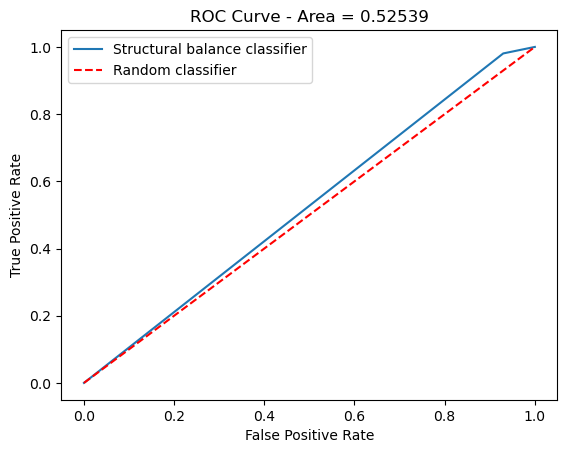

In [197]:
plt.plot(fpr, tpr, label = 'Structural balance classifier')
plt.plot([0, 1], [0, 1],'r--', label = 'Random classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score))
plt.legend()
plt.show()

In [198]:
#B

new_df['pred_B'] = new_df['PP'] >= new_df['PN']

new_df['pred_B'] = new_df['pred_B'].apply(prediction)

In [199]:
# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(new_df['VOT'], new_df['pred_B'])
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr) 

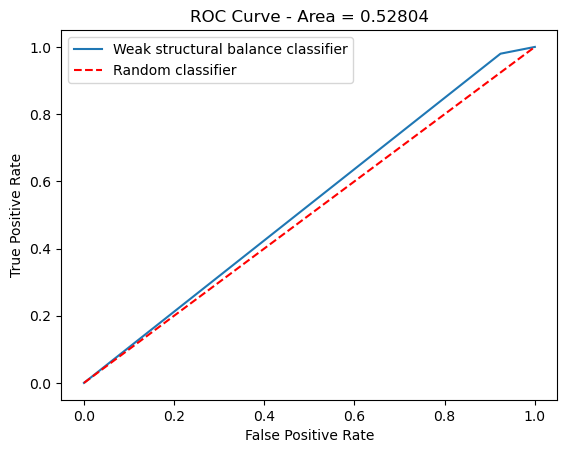

In [200]:
plt.plot(fpr, tpr, label = 'Weak structural balance classifier')
plt.plot([0, 1], [0, 1],'r--', label='Random classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score))
plt.legend()
plt.show()

**3.3** To determine if the differences in the classifiers from task **3.2** occur solely due to chance, follow the following bootstrap procedure, using 200 iterations:

- **A)** Randomly sample the entire dataset (i.e., votes from the dataframe constructed in task **3.1**) with replacement;
- **B)** Compute the difference of the AUC/ROC for the two classifiers on the entire dataset.

Then use the distribution of AUC/ROC differences (one difference per bootstrap iteration) to estimate the 95% confidence interval for the AUC/ROC difference.

In [201]:
# 3.3 
def do_bootstrap(data, n=200):
    sample_statistic = [] 
    for _ in range(n):
        sampled_data = data.sample(n=len(data), replace=True)
        
        # Compute the False Positive Rate and True Positive Rate
        fpr, tpr, _ = roc_curve(sampled_data['VOT'], ((sampled_data['PP'] + sampled_data['NN']) >= sampled_data['PN']).apply(prediction))
        # Compute the area under the fpt-tpf curve
        auc_score_A = auc(fpr, tpr) 
        
        # Compute the False Positive Rate and True Positive Rate
        fpr, tpr, _ = roc_curve(sampled_data['VOT'], (sampled_data['PP'] >= sampled_data['PN']).apply(prediction))
        # Compute the area under the fpt-tpf curve
        auc_score_B = auc(fpr, tpr) 
        
        sample_statistic.append(auc_score_A - auc_score_B)
        
    return (np.percentile(sample_statistic, 2.5), np.percentile(sample_statistic, 97.5))

In [202]:
CI = do_bootstrap(new_df)

In [203]:
CI

(-0.003022279175060291, -0.0022702617023058896)

**3.4 ** **/Discuss:**/ According to the results in tasks **3.2** and **3.3**, which theory better predicts actual edge signs, structural balance theory or the weak structural balance theory? 

**A3.4** *YOUR ANSWER HERE*

According to the 95% confidence interval it seems that the weak structural balance theory better predicts the edge sign. In fact the auc score difference between theory A and theory B is in favour of theory B (weak theory).
But we remark that the difference is not huge!

**3.5** How accurately can we predict the vote with more sophisticated features and algorithms?

- Create a TF-IDF representation of the text of each vote  using `sklearn`'s vectorizer ([`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)) with the parameters `max_features=150` and `stop_words='english'`.
- Split the  dataset into training and test sets using sklearn [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) using parameters `test_size=0.1` and  `random_state=42`.

- Then, train two logistic regression models ([`sklearn.linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)) using parameters `loss='log_loss'` and `max_iter=2000` considering:

    - **1)** the TF-IDF feature vector

    - **2)** the TF-IDF feature vector and the features `PP`, `NN`, `PN`, `P`, and `N` related to the graph.

- Last, report the AUC/ROC of each model in the test set.

In [205]:
class_df = new_df.dropna(subset=['TXT_PROCESSED', 'VOT']).copy()

In [206]:
# 3.5
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=150, stop_words='english')
X = vectorizer.fit_transform(class_df['TXT_PROCESSED'])

In [208]:
y = class_df['VOT']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [209]:
from sklearn.linear_model import SGDClassifier

In [210]:
#1

clf = SGDClassifier(max_iter=2000, loss='log_loss')
clf.fit(X_train, y_train)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test))
# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr) 

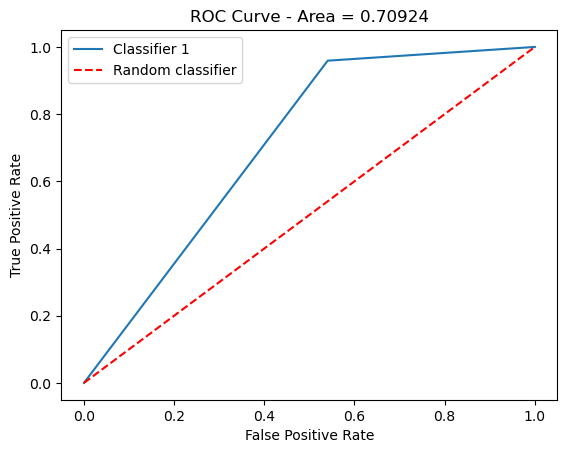

In [211]:
plt.plot(fpr, tpr, label = 'Classifier 1')
plt.plot([0, 1], [0, 1],'r--', label='Random classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Area = {:.5f}".format(auc_score))
plt.legend()
plt.show()

I do not know how to also use the PP, NN, PN, P and N features

In [228]:
vectorizer = TfidfVectorizer(max_features=150, stop_words='english')
X_2 = vectorizer.fit_transform(class_df[['TXT_PROCESSED', 'PP', 'NN', 'PN', 'P', 'N']])

In [229]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.1, random_state=42)

clf_2 = SGDClassifier(max_iter=2000, loss='log_loss')
clf_2.fit(X_train_2, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [6, 162920]

**3.6** **/Discuss:**/  According to the results in task **3.5**, does information from the graph help in the task of predicting the vote even when using the text?  What kind of subsequent analysis would make you trust that the results are not obtained simply by chance? (No need to actually perform that subsequent analysis here.) 

**A3.6** *YOUR ANSWER HERE*

I would look at the macro averaged F1 score. It is possible that if the outcome variable is unbalaced, it drives the result to high accucary but it is better to look at the F1 score.

According to the previous classifier, yes it is better with the text info (logistic regression) that the previous classifiers. Unfortunately I can not tell about the other features :(

**3.7** Putting on your observational studies hat, run two logistic regressions using `statsmodels`.
- In the first regression, the vote is the outcome, and `PP`, `NN` and `PN` are the predictors.
- In the second regression, the vote is the outcome, and `PP`, `NN`, `PN`, and `N` are the predictors.

In [244]:
def conv(x):
    
    if x == 1:
        return 1
    else:
        return 0

new_df['VOT_n'] = new_df.VOT.apply(conv)

In [250]:
# 3.7

mod = smf.logit(formula=' VOT_n ~ PP + NN + PN', data=new_df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.514594
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  VOT_n   No. Observations:               167003
Model:                          Logit   Df Residuals:                   166999
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Jan 2023   Pseudo R-squ.:                 0.01804
Time:                        17:35:10   Log-Likelihood:                -85939.
converged:                       True   LL-Null:                       -87517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2781      0.006    206.255      0.000       1.266       1.290
PP             0.2493      0.

In [251]:
mod = smf.logit(formula=' VOT_n ~ PP + NN + PN + N', data=new_df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.487994
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  VOT_n   No. Observations:               167003
Model:                          Logit   Df Residuals:                   166998
Method:                           MLE   Df Model:                            4
Date:                Tue, 17 Jan 2023   Pseudo R-squ.:                 0.06880
Time:                        17:35:14   Log-Likelihood:                -81496.
converged:                       True   LL-Null:                       -87517.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6227      0.008    212.945      0.000       1.608       1.638
PP             0.2535      0.

**3.8** **/Discuss:**/   Explain what the coefficient associated with `PP` means in the first regression. Is it in accordance with structural balance theory?

**A3.8** *YOUR ANSWER HERE*

In the first regression if PP increase by one unit the chanche of having a positive vote increases by 0.25. This is consistent with the structural balance theory because a positive positive interaction increase the chance of voting positive.

**3.9** **/Discuss:**/   Compare the coefficients associated with `PN` and `NN` in the first vs. the second regression. Present a reason that may explain this difference.

**A3.9**  *YOUR ANSWER HERE*

Both coefficients are negative in both regressions. They are always significant.

In the second regression PN and NN have less positive values than in the first regression. This is due to the fact that the N coefficient of the second regression explains in part the outcome and therefore it takes into account the difference in coefficient between the two regressions for PN and NN

---